In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from tqdm import tqdm

import scipy.special

import delfi.distribution as dd
import delfi.generator as dg
import delfi.inference as infer
import delfi.utils.io as io
import delfi.summarystats as ds

from lfimodels.glm.GLM import GLM
from lfimodels.glm.GLMStats import GLMStats
from delfi.utils.viz import plot_pdf

import lfimodels.glm.utils as utils

In [2]:
params = {'figure.titlesize': 'xx-large' }
pylab.rcParams.update(params)

In [3]:
# The actual prior variance
prior_var = 1

noise_var = 0.1

# Error bars in the last figure
percentile = 0.05

use_marcels_colorscheme = True

seed = 420

len_filter = 3

nrounds = 5

m = GLM(seed=seed, len_filter=len_filter)

true_params, labels_params = utils.obs_params(len_filter=len_filter)
obs = utils.obs_data(true_params, seed=seed)
obs_stats = utils.obs_stats(true_params, seed=seed)

In [4]:
rerun = False  # if False, will try loading file from disk

try:
    assert rerun == False, 'rerun requested'
    sam = np.load('glm_samples.npz')['arr_0']
except:
    sam = utils.pg_mcmc(true_params, obs)
    np.savez('glm_samples.npz', sam)

100%|██████████| 499999/499999 [02:16<00:00, 3667.13it/s]


In [5]:
def sim_with_gaussian_pp(nrounds, N, alpha=0, seed=seed):
    p = utils.smoothing_prior(n_params=m.n_params, seed=seed)
    s = GLMStats(n_summary=m.n_params)
    g = dg.Default(model=m, prior=p, summary=s)

    res = infer.SNPE(g, 
                     obs=obs_stats, 
                     convert_to_T=None,
                     n_hiddens=[10], 
                     seed=seed, 
                     pilot_samples=100,
                     svi=True,
                     reg_lambda=0.01,
                     prior_mixin=alpha,
                     prior_norm=False)

    logs, tds, posteriors = res.run(n_train=N, 
                                    n_rounds=nrounds, 
                                    minibatch=100, 
                                    epochs=1000, 
                                    round_cl=3)
    
    return { 'true_params' : true_params, 'logs' : logs, 'tds' : tds, 'posteriors' : posteriors }


In [11]:
# List of sample sizes to consider
# Nlist = [ 100, 300, 1000, 3000 ]
Nlist = [ 100, 300, 1000 ]

# List of prior mixin values to consider
alphas = [ 0 ]

dists = { "Gaussian" : sim_with_gaussian_pp }#, "Student's T" : sim_with_studentsT_pp }

# Run simulations (this takes a while)
sim_lists = { d : { alpha : { n : dists[d](nrounds, n, alpha=alpha) for n in Nlist } \
                    for alpha in alphas } \
              for d in dists }

In [12]:
def plot_run(posterior, true_params):
    fig, ax = plot_pdf(posterior.xs[0], 
                       lims=[-2,2], 
                       samples=sam, 
                       gt=true_params, 
                       figsize=(4,4));

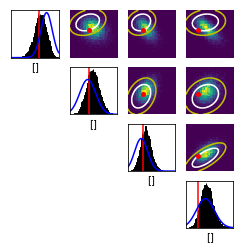

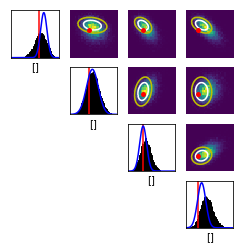

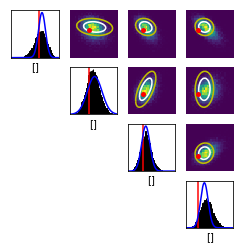

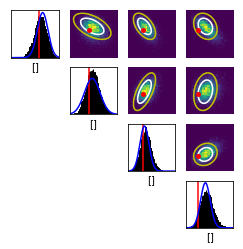

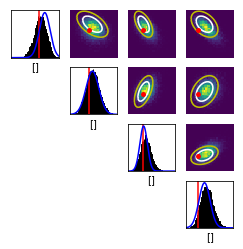

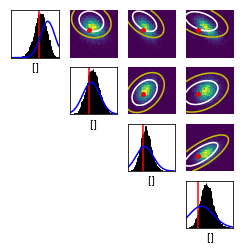

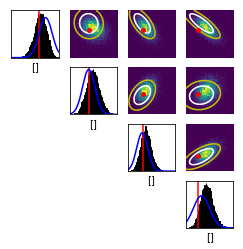

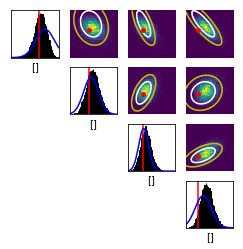

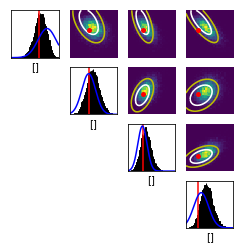

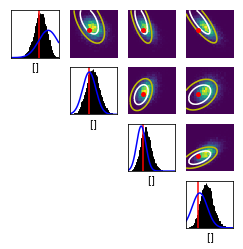

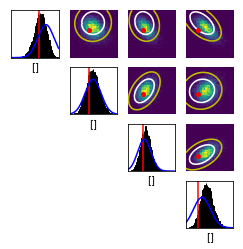

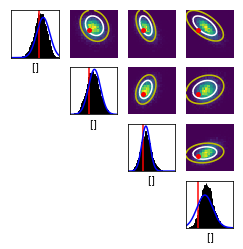

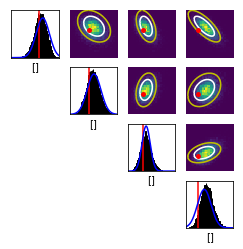

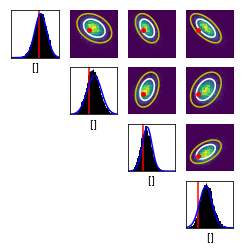

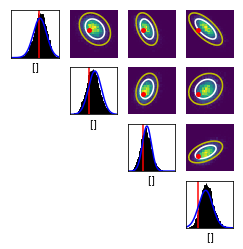

In [13]:
for d in dists:
    for alpha in alphas:
        for n in Nlist:
            posteriors = sim_lists[d][alpha][n]['posteriors']
            for r in range(5):
                posterior = posteriors[r]
                plot_run(posterior, true_params)